In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import normalize
from sklearn.metrics import jaccard_score
import os
import math
import pickle
from collections import OrderedDict
from abc import abstractmethod
import networkx as nx
import os
import sys
import numpy as np

# ------------------------ #

from utils_v1 import Goodall3

# ------------------------ #

In [2]:
'''
Node objects
'''


class node_class:
    _id = 0

    def __init__(self, type):
        self.type = type
        self.score = 0
        self._id = node_class._id
        return

    @abstractmethod
    def set_score(self, s):
        self.score = 0

    @staticmethod
    def increment_id():
        node_class._id += 1


class node_entity(node_class):
    def __init__(self, domain_id, entity_id):
        node_class.__init__(self, type='entity')
        self.domain = domain_id
        self.entity = entity_id
        self.id = node_entity._id
        node_class.increment_id()


class node_record(node_class):

    def __init__(self, record_id):
        node_class.__init__(self, type='record')
        self.record_id = record_id
        node_class.increment_id()

In [3]:
'''
Some simple data to play around with 
'''

'\nSome simple data to play around with \n'

In [4]:
def create_data():
    # 195 points
    df_1 = pd.read_csv('anomaly_syhthetic_1.csv')
    # 5 points of predefined anomaly
    df_2 = pd.read_csv('hand_built_anomaly.csv')

    df = df_1.append(df_2, ignore_index=True)

    cols = list(df.columns)

    # col id(number) : column name
    cols_dict = {
        e[1]: e[0] for e in enumerate(cols, 0)
    }

    def baptize(
            row,
            col,
            cols_dict
    ):
        _i = cols_dict[col]

        return str(_i) + '_' + str(row[col])

    for col in cols:
        print('--', col)
        df[col] = df.apply(
            baptize,
            axis=1,
            args=(
                col,
                cols_dict,
            )
        )

    df['id'] = list(df.index)

    # since last few
    _anomalies = list(range(195, 200))
    normal_samples = [int(_ * 150) for _ in np.random.random(5)]
    
    return df, _anomalies, normal_samples


In [5]:
'''
A_ft: F x T
'''
def get_A_ft(graph, F, T, F_id_dict):
    _F_id_dict = {
        v: k for k, v in F_id_dict.items()
    }
    a = np.zeros([len(F), len(T)])
    for e in graph.edges():

        i = None
        j = None

        if ((e[0] in F) and (e[1] in T)):
            j = _F_id_dict[e[0]]
            i = e[1]

        elif ((e[0] in T) and (e[1] in F)):
            i = _F_id_dict[e[1]]
            j = e[0]

        if i is not None and j is not None:
            a[i][j] = 1

    return a

In [6]:
# ------------------------ #
# find the _id of a node of entity type
# ------------------------ #
def find_entity_id_in_graph(
        graph,
        domain,
        entity_identifier
):
    for n in list(graph.nodes):
        obj = graph.node[n]['data']
        if obj.type == 'entity' and obj.domain == domain and obj.entity == entity_identifier:
            return obj._id
    return None


def find_record_id_in_graph(
        graph,
        entity_identifier
):
    for n in list(graph.nodes):
        obj = graph.node[n]['data']
        if obj.type == 'record' and obj.record_id == entity_identifier:
            return obj._id
    return None

In [7]:
def add_record_feature_edges(
        graph,
        df,
        record_dict,
        entities_dict,
        id_col='id'
        ):

    entity_cols = list(df.columns)
    entity_cols.remove(id_col)

    domain = 0
    entity_prob_dict = {}

    for col in entity_cols:
        # probability of each entity
        count = Counter(list(df[col]))
        for e_name,val in count.items():
            x = find_entity_id_in_graph(
                graph,
                domain,
                e_name
            )
            entity_prob_dict[x] = (val+1)/len(df)
        domain += 1

    for i,row in df.iterrows():
        _id = row[id_col]
        n1 = find_record_id_in_graph(graph,_id)
        domain = 0
        for _, e_name in row.to_dict().items():
            if _ == id_col: continue
            x = find_entity_id_in_graph(
                graph,
                domain,
                e_name
            )
            graph.add_edge(
                n1,
                x,
                weight=entity_prob_dict[x]
            )
            domain += 1

    return graph

In [8]:
# ------------------------ #
# Capture both feature interaction & feature importance(rarity)
# ------------------------ #
def add_feature_edges(
        graph,
        df,
        entities_dict,
        id_col='id'
):
    entity_cols = list(df.columns)
    entity_cols.remove(id_col)
    num_entities = len(entities_dict)

    # entity ids can be from k to k+n
    # offset this
    eId2arrayIndex = {}

    _start = min(entities_dict.keys())
    _end = max(entities_dict.keys())
    _i = 0
    for _ in range(_start, _end + 1):
        eId2arrayIndex[_] = _i
        _i += 1
    arrayIndex2eID = {v: k for k, v in eId2arrayIndex.items()}

    # idf is 1/p
    idf = np.zeros([num_entities])
    domain = 0

    for col in entity_cols:
        # probability of each entity
        _prob = Counter(list(df[col]))

        # find _id for each of the entities
        for entity_identifier, v in _prob.items():
            idx = find_entity_id_in_graph(
                graph,
                domain,
                entity_identifier
            )
            print(entity_identifier, idx)
            _idx = eId2arrayIndex[idx]
            p = (v + 1) / len(df)
            idf[_idx] = math.sqrt(1 / p)
        domain += 1
    
    idf = np.reshape(
        normalize(
            np.reshape(
                idf,
                [1, -1]),
            norm='max'
        ), [-1]
    )
    
    
    # ----------
    # Calculate co-occurrence matrix
    # ----------
    coocc_matrix = np.zeros(
        [num_entities, num_entities],
        dtype=np.float32
    )

    _tmp = {e[1]: e[0] for e in enumerate(entity_cols, 0)}
    for uv in itertools.combinations(entity_cols, 2):
        print('---', uv)
        tmp_df = df[list(uv)]
        tmp_df_1 = pd.DataFrame(tmp_df.groupby(uv).size().reset_index(
            name='counts')
        )
        _d1 = _tmp[uv[0]]
        _d2 = _tmp[uv[1]]

        for i, row in tmp_df_1.iterrows():
            # u and v should be array indices of co-occ matrix
            val1 = row[0]
            val2 = row[1]
            _i1 = find_entity_id_in_graph(
                graph, _d1, val1
            )
            _i2 = find_entity_id_in_graph(
                graph, _d2, val2
            )

            u = eId2arrayIndex[_i1]
            v = eId2arrayIndex[_i2]

            coocc_matrix[u][v] = int(row['counts'])
            coocc_matrix[v][u] = coocc_matrix[u][v]
    
    print('un normalized co-occ',coocc_matrix)
    
    coocc_matrix = normalize(
        coocc_matrix,
        axis=1,
        norm='max'
    )
    
    for i in range(coocc_matrix.shape[0]):
        coocc_matrix[i][i] = 1
    
    a = np.matmul(np.transpose(idf), idf)
    b = coocc_matrix

    # element wise multiplication
    c = a * b
    show_heatmap(c)

    # add the edges with weights

    for i in range(c.shape[0]):
        for j in range(i, c.shape[1]):
            _n1 = arrayIndex2eID[i]
            _n2 = arrayIndex2eID[j]
            graph.add_edge(_n1, _n2, weight=b[i][j])

    return graph

In [9]:
# ---------------------------------- #
def show_heatmap(arr):
    if len(arr.shape) == 1:
        arr = np.reshape(arr, [-1, 1])

    plt.imshow(arr, cmap='hot', interpolation='nearest')
    plt.tight_layout()
    plt.show()
    plt.close()

In [10]:
'''
Create graph 
'''

def preprocess_1(refresh=False):

    if os.path.exists('datapkl_1.pkl') and refresh == False:
        with open('datapkl_1.pkl', 'rb') as fh:
            result = pickle.load(fh)
            df = result[0]
            labelled_indices = result[1]
            g = result[2]
            return df, labelled_indices , g

    df, _anomalies, normal_samples = create_data()
    # consistent ordering of nodes
    g = nx.OrderedGraph()

    # --------------------- #
    # Add nodes
    # --------------------- #
    record_nodes_list = list(df['id'])
    record_nodes_dict = OrderedDict()
    
    for rn in record_nodes_list:
        _node = node_record(
            record_id=rn
        )
        g.add_node(_node._id, data=_node)
        record_nodes_dict[_node._id] = _node

    # enytity nodes
    entity_node_dict = OrderedDict()

    domain = 0
    for col in list(df.columns):
        if col == 'id': continue
        e_list = sorted(set(df[col]))
        for _e in e_list:
            _node = node_entity(domain_id=domain, entity_id=_e)
            g.add_node(_node._id, data=_node)
            entity_node_dict[_node._id] = _node
        domain += 1

    print('Number of nodes', g.number_of_nodes())

    '''
    Add in weights
    '''
    g = add_feature_edges(g, df, entity_node_dict)
    show_heatmap(nx.adjacency_matrix(g).todense())

    print('Number of edges', g.number_of_edges())

    num_record_nodes = len(record_nodes_dict)
    num_entity_nodes = len(entity_node_dict)

    # Add in edges between features & records
    g = add_record_feature_edges(
        g,
        df,
        record_nodes_dict,
        entity_node_dict
    )

    show_heatmap(nx.adjacency_matrix(g).todense())
    labelled_indices = []

    num_nodes = g.number_of_nodes()
    
    '''
    Initial labels
    Set positive to +1
    Set negative to -1
    Set unlabelled to 0
    '''
  
    initial_labels = np.zeros([num_nodes])
    
    for a in _anomalies:
        x = find_record_id_in_graph(
            g,
            a
        )
      
        initial_labels[x] = +1
    for a in normal_samples:
        x = find_record_id_in_graph(
            g,
            a
        )
        initial_labels[x] = -1
    show_heatmap(initial_labels)
    result = [df,initial_labels,g]     
    with open('datapkl_1.pkl', 'wb') as fh:
        pickle.dump(result, fh, pickle.HIGHEST_PROTOCOL)
        
    return df, initial_labels, g


In [11]:
# ----------------------------------------- #

In [26]:
def semi_supervised(g, Y):
    
    # calculate laplacian
    L = nx.linalg.normalized_laplacian_matrix(g)
    show_heatmap(L.todense())
    L = L.todense()
    Y_orig = np.reshape(Y,[-1,1])
    Y_old = np.reshape(Y,[-1,1])
    print(L.shape)
    alpha = 0.1
    iterate = True
    Y_new = None
    iter = 0
    error_epsilon = 0.00001
    while iterate:
        a = (1-alpha) * Y_orig
        b = alpha * np.matmul(L,np.reshape(Y_old,[-1,1]))
        Y_new = a + b
        
        # ensure old labels are maintained
        for i in range(Y_orig.shape[0]):
            if Y_orig[i][0] == 1.0 or Y_orig[i][0] ==-1.0:
                Y_new[i][0]=Y_orig[i][0]
        diff = np.max(np.abs(Y_old - Y_new))
    
        if iter%100 == 0:
            print('iter :',iter,' |  diff :', diff)
        iter += 1
        Y_old = np.array(Y_new)
                
        if diff <= error_epsilon or iter > 10000 :
            iterate = False
            print(' difference = ', diff)
            
    print(' Number of iterations ', iter)
    return Y_new
         

223 1276


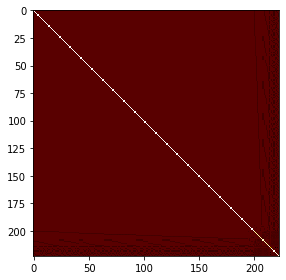

(223, 223)
iter : 0  |  diff : 0.013758945796478631
 difference =  2.7256164614603007e-06
 Number of iterations  5


In [27]:
def main():
    # original lables in labelled_indices
    df, labelled_indices, g = preprocess_1(False)
    print(g.number_of_nodes(),g.number_of_edges())
    # new labels
    Y_new = semi_supervised(g,labelled_indices)
    
    return labelled_indices,Y_new
        
a,b = main()

In [30]:
b

matrix([[-4.99135751e-05],
        [-4.24761818e-05],
        [ 5.92110818e-05],
        [ 7.78943830e-05],
        [ 6.60473810e-05],
        [ 8.45326863e-05],
        [-4.19677820e-05],
        [ 6.04004979e-05],
        [-1.06561064e-04],
        [ 6.75289306e-05],
        [ 8.52421827e-05],
        [-4.18758798e-05],
        [ 4.51509347e-06],
        [-6.90216653e-05],
        [-3.36944207e-05],
        [-9.16348333e-05],
        [ 2.13027159e-05],
        [ 8.62110721e-05],
        [-6.90070842e-05],
        [ 6.18380379e-05],
        [-5.99544249e-05],
        [ 4.04390788e-05],
        [ 2.36871903e-05],
        [ 4.45490545e-05],
        [ 6.98012388e-05],
        [-5.43011366e-05],
        [-1.19803377e-04],
        [ 3.13120404e-05],
        [ 7.12799045e-05],
        [ 6.72384135e-05],
        [-1.19849643e-04],
        [-9.22195075e-06],
        [ 3.25015753e-05],
        [ 5.38811227e-05],
        [-6.21970166e-05],
        [ 4.95525040e-05],
        [-1.19913775e-04],
 

matrix([[-1.11628696e-05],
        [-9.51020156e-06],
        [ 1.33212267e-05],
        [ 1.75290532e-05],
        [ 1.48519341e-05],
        [ 1.90602567e-05],
        [-9.37774654e-06],
        [ 1.36071443e-05],
        [-2.38804257e-05],
        [ 1.52061255e-05],
        [ 1.91869809e-05],
        [-9.38564480e-06],
        [ 1.02729778e-06],
        [-1.55003448e-05],
        [-7.50070182e-06],
        [-2.05291282e-05],
        [ 4.82909411e-06],
        [ 1.94007501e-05],
        [-1.54547188e-05],
        [ 1.39381980e-05],
        [-1.34387888e-05],
        [ 9.10202585e-06],
        [ 5.32153053e-06],
        [ 1.00200068e-05],
        [ 1.56960713e-05],
        [-1.21961038e-05],
        [-2.69077444e-05],
        [ 7.00215528e-06],
        [ 1.60411316e-05],
        [ 1.51162445e-05],
        [-2.69058758e-05],
        [-2.06785170e-06],
        [ 7.28212203e-06],
        [ 1.20970600e-05],
        [-1.39219720e-05],
        [ 1.11512233e-05],
        [-2.69000885e-05],
 